# Virtual Mile of Miles: Building a Monte Carlo statistical model in 3 days

Running clubs in the Greater Southampton area annually compete in the 'Mile of Miles' team competition, typically held in June. Given the cancellation of events in 2020, my club decided to replicate it with our own, virtual event. In this virtual Mile of Miles, there are 12 teams of 10 runners, drawn randomly from a hat beforehand. Each team member completes the fastest 1 mile time they can, at any time, on any net zero elevation route in a set week.  The team's time is the summation of the each team member's 1 mile time. Every second counts!

Before the race was completed, I was asked if I fancied guessing the outcome. Given this little challenge, I decided to build a simple statistical model to simulate the event using some simple, data-driven statistics. I did this in 3 days in June, 2020, in between doing my PhD in Astrophysics at University of Southampton. In this notebook I step through the method I employ here, outlining both its strengths and pitfalls!

In [1]:
import re
import numpy as np
import numpy.random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

# Data

1 mile races are uncommon. However, in addition to the annual Mile of Mile events, there is an annual summer series of 1 mile events, known as the 'Magic Mile', hosted on Southampton Common. We can therefore use historical data from these events as input data to our model.

In order to estimate each individual's 1 mile time, we need to find a relation between some readily available data and the limited historic 1 mile available to us. Data from timed 5k events are readily accessible, in the form of parkrun results – parkruns are free, weekly, timed 5k events hosted across UK (and worldwide). Southampton parkrun regularly attracts over 1000 runners, and most runners in this competition have completed at least one of these events in 2020, so it sets a standard we can measure from.

I pulled the fastest 5km time of 2020 for each athlete in the competition, run at Southampton parkrun. For the small number of athletes that this didn't apply to, I took the individual's best at another parkrun in 2020, or their best 5km time in 2019, or in the worst case, a general estimation from their training group, in that order. 

I then pulled the last 3 years’ worth of 1 mile race data (from both Mile of Miles and Magic Mile competitions) and matched results to any participant running in this virtual competition. Many runners have not completed a 1 mile race, while some have completed many. Both mile and 5k data for this analysis were stored on a spreadsheet (saved as a .csv file), which is where this analysis begins.

It is these data that we will use to form a predictive relation, which forms the basis of the Monte-Carlo simulation.

In [3]:
# Read the csv file containing runners and best 2020 5k & (all-time) mile times:

df = pd.read_csv("/Users/dia1u17/Desktop/DataWork/Running_Projects/Mile_of_miles.csv") 

# Do some data cleaning

df = df.drop(columns=['Team 1', 'Unnamed: 1', '10k']) # Drop unneccesary columns

df = df.dropna(how='all')  # Drop rows if all NaNs (i.e. between groups on the spreadsheet or added rows)

df.head() # The resulting dataframe looks like this:

,5k,MoM17,MoM18,MoM19,MM17a,MM17b,MM17c,MM17d,MM17e,MM18a,MM18b,MM18c,MM18d,MM18e,MM19a,MM19b,MM19c,MM19d,MM19e
0,29:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26:09:00,NaN,NaN,NaN,07:03,NaN,06:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32:59:00,NaN,NaN,NaN,08:06,NaN,08:03,08:06,08:04,08:53,NaN,09:34,09:03,NaN,NaN,NaN,09:32,09:13,09:19


Each index represents an individual athlete (names removed for confidentiality). The '5k' column shows their selected time (i.e. best 5k of 2020, 2019...etc, as above). All other columns show the mile time from past 'Mile of Mile' (MoM) events or 'Magic Mile' (MM) events -- NaN values if the athlete did not compete.

# Data search for 5k/Mile times

We now need to find and match any mile results with 5k performance. The limitation here is that mile races were across different years and we're comparing to only a single 5k time (in 2020). We need to keep this limitation in mind.

Let's first convert race times into seconds.

In [4]:
def mins_secs(time):
    "Function to convert minutes (type: strings) into seconds (type: floats)"
    
    if len(time) > 6: # If format is XX:XX:XX 
        seconds = float(time[:2])*60 + float(time[3:5]) # Convert times to seconds
        
    elif len(str(time)) < 6: # If format is XX:XX
        seconds = float(time[:2])*60 + float(time[3:])  # Convert times to seconds
    
    return seconds

In [5]:
# Convert 5k times to seconds and insert new column

col_names = df.columns  # Obtain column names as list

new_col_names = col_names.insert(1,'5k_secs')  # Choose position for new columnname 

df['5k_secs'] = [mins_secs(time) for time in df['5k'].values]  # Populate new column as 5k time in seconds

df = df[new_col_names]  # Re-order daatframe appropriately

df.head()

,5k,5k_secs,MoM17,MoM18,MoM19,MM17a,MM17b,MM17c,MM17d,MM17e,MM18a,MM18b,MM18c,MM18d,MM18e,MM19a,MM19b,MM19c,MM19d,MM19e
0,29:02:00,1742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26:28:00,1588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28:59:00,1739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26:09:00,1569.0,NaN,NaN,NaN,07:03,NaN,06:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32:59:00,1979.0,NaN,NaN,NaN,08:06,NaN,08:03,08:06,08:04,08:53,NaN,09:34,09:03,NaN,NaN,NaN,09:32,09:13,09:19


Now let's populate a sample of mile times, set against the corresponding 5k time, over all athletes.

In [6]:
# Create a new dataframe consisting of only mile times:

df_miles = df.drop(columns=['5k', '5k_secs']) 

df_miles = df_miles.dropna(how='all')  # Drop any rows where an athlete has no historic mile results

miletimes = []  # Initialise our list of historic mile times

for i in range(len(df_miles)):
    mask = pd.isna(df_miles.iloc[i].values)  # For each row create a mask of NaN values
    miletimes.append(df_miles.iloc[i][~mask].values.tolist())  # Then append a list of all non-Nan values into a list

miletimes = [mins_secs(time) for sublist in miletimes for time in sublist]  # Flatten into a single 1d list

In [7]:
# Now let's get our corresponding list of 5k times:

indexes = df_miles.index  # Find which athletes have historic mile time 

df_filtered = df[df.index.isin(indexes)]  # Create a filtered dataframe of only these athletes

mile_count = (len(df_miles.columns) - pd.isna(df_miles).sum(axis=1)).values  # Count how many mile races they've done

fivektimes = []  # Initialise our list of historic 5k times

for i,val in enumerate(mile_count):  # For each athlete in the filtered dataframe
    for j in range(val):  
        fivektimes.append(df_filtered['5k_secs'].values[i])  # Append the athlete's 5k time for as many mile races 


We now have a list of all the historic mile times in our sample, matched with the 5k times that each athlete recorded in 2020, as a measure of overall ability. 

# Regression using a linear model

When investigating the relationship between historic mile and 5k performance we find a linear relationship -- faster 5k runners run faster 1 mile races.

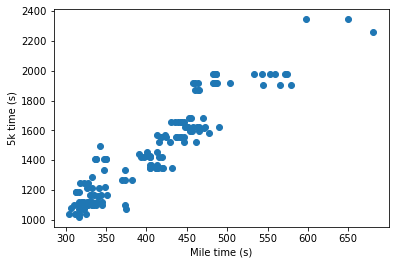

In [8]:
# Show the underlying relationship:
plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes)

plt.show()

## Model fitting

As this relationship is approximately linear, we want to describe this relation with a linear model. There exist numerous methods to achieve this, including manually defining a loss function using maximum likelihood statistics. Due to the simple nature of these data however, a standard least-squares methodology (i.e. the scipy.optimize function curve_fit) will suffice.

In [9]:
def linear_line(x, m, c):
    ''' Function to define our linear model '''
    y = m*x + c
    return y

Now we perform our linear regression using curve_fit.

In [10]:
popt, pcov = curve_fit(linear_line, miletimes, fivektimes)  # curve_fit minimisation routine
m_min, c_min = popt  # Initial estimate model parameters

x_plot = np.arange(275,700)  # Range of mile times in seconds

Model = linear_line(x_plot, m_min, c_min)  # Return our best fitting model

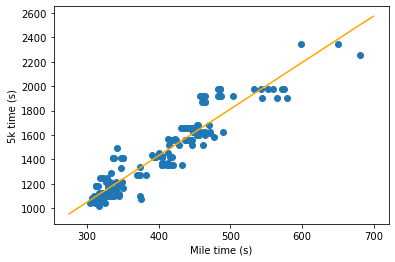

In [11]:
# Let's visualise this:
plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes)

plt.plot(x_plot, Model, color='orange')  # Plot on our model

plt.show()

## Bootstrap-with-replacement

In this analysis we will employ simple, frequentist statistics. In order to describe the uncertainty on this linear model we will employ a bootstrap-with-replacement method, using the function below. 

This method randomly selects data points from the sample, up to a number equal to the total number of data in the sample, and is allowed to re-select the same data points multiple times. For N iterations of this process, we fit this new ‘bootstrapped’ dataset with our linear model and form a discrete distribution of model parameters from all iterations.

It is worth noting here that the data appear to suffer from some amount of observational bias towards faster runners – particularly those with 5k times < ~28mins (or 1680 seconds). The median parkrun time of runners in my club is found to be ~26 minutes (see modelling parkrun results notebook).

In [12]:
def Bootstrap_Continuum(N, Xs, Ys, m_guess, c_guess):
    ''' Function to perform a bootstrapping-with-replacement routine and 
    return the resulting distribution of parameters '''
    
    c_list = [] 
    m_list = []

    startindex = list(range(len(Xs)))  # Set up index range: (0 - last index in data set)
        
    for iter in range(N):
       
        index = np.random.choice(startindex, len(startindex), replace=True)                
        Rnd_Xs = Xs[index]  # Draws selection of random data from data-set 
        Rnd_Ys = Ys[index]  

        Boot_opt, Boot_cov = curve_fit(linear_line, Rnd_Xs, Rnd_Ys)  # Fit bootstrapped dataset as before
        m_boot, c_boot = Boot_opt  
   
        m_list.append(m_boot)  # Add these parameter fits to the list
        c_list.append(c_boot) 
        

    c_list = np.array(c_list)  # Return arrays of parameters
    m_list = np.array(m_list)

    return m_list, c_list


In [13]:
# Let's run the bootstrap over N iterations:

N = 2000  # Number of bootstrap iterations
m_list, c_list = Bootstrap_Continuum(N, np.array(miletimes), np.array(fivektimes), m_min, c_min)  # Return parameter lists

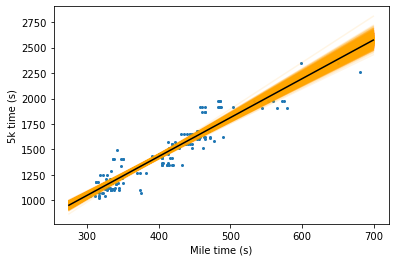

In [14]:
# And now plot the N bootstrapped models, which directly encapsulates uncertainty in the model
plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes, s=4)

for i in range(N):  # Plot each bootstrap iteration
    plt.plot(x_plot, linear_line(x_plot, m_list[i], c_list[i]), color='orange', alpha=0.1)  

plt.plot(x_plot, Model, color='black')  # And plot the maximum likelihood model

plt.show()

# Confidence Limits

The bootstrap inherently creates confidence limits on our model, which we can utilise in this analysis. Here, I make the assumption that these errors are Gaussian distributed.

In [15]:
# Collate all the bootstrap model outputs together
bootstrap_lines = [linear_line(x_plot, m_list[i], c_list[i]) for i in range(N)]

In [16]:
# Determine the ideal bootstrap fit from the median, and 16/84 percentiles used for 1 sigma errors
low_sig, bootstrap_fit, upp_sig = np.percentile(bootstrap_lines, [16, 50, 84], axis=0)

In [17]:
# Assuming these errors to be Gaussian, we can calculate the standard deviation across all possible mile times 
std_devs = (upp_sig - low_sig)/2

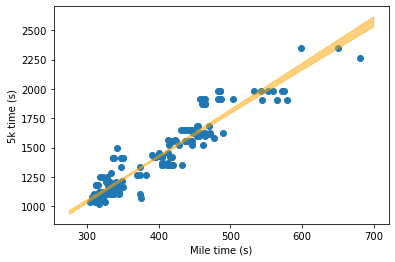

In [18]:
# Show the 1 sigma confidence intervals which constrain our model
plt.figure()

plt.xlabel('Mile time (s)')
plt.ylabel('5k time (s)')

plt.scatter(miletimes, fivektimes)

plt.fill_between(x_plot, low_sig, upp_sig, color='orange', alpha=0.5)

plt.show()

These errors appear relatively small (but are confirmed seperately by an MCMC method) and suggest the linear model is well constrained to these sample data. 

# Monte-Carlo

A Monte Carlo method can now be implemented to simulate N iterations of fake data, to effectively sample from our model. Using the 1-sigma errors constrained from the bootstrap, we can use the assumption that these errors are Gaussian distributed around the maximum-likelihood fit.

Here we define a Monte Carlo function to run over N_sim iterations, before running this function to effectively simulate the race.

In [19]:
def MC(N_sim, Model_params, std_devs, x_plot):
    """Monte Carlo function run over N_sims, which returns a dataframe containing results for 
    all 12 teams (in columns), over every iteration (as rows)"""
    
    df_MC = pd.DataFrame()  # Initialise results dataframe
        
    All_Times = []    
        
    Team_numbers = np.arange(1,13)  
    
    m_min, c_min = Model_params
        
    model_predictions = df['5k_secs'].apply(lambda time: (time - c_min) / m_min)  # 'Exact' predicted times from model
    
    for n in range(N_sim):  # Start MC running over N_sim iterations
            
        # Simulate mile times assigning Gaussian errors from the pre-defined model
        mile_draws = [np.random.normal(time, std_devs[np.argwhere(x_plot == int(time))[0][0]])  
                          for time in model_predictions]
        
        Team_times = []
        for team in Team_numbers:  # Loop over each team
            
            Times = mile_draws[(team-1)*10:team*10]  # Slice out each team's (of 10) times
            Team_times.append(np.sum(Times))  # Collect the team's total time (i.e. the sum of times)
            
        All_Times.append(Team_times)  # Append to a master list (this is faster than appending straight to a dataframe)

    # The MC is complete, so now we collect the output into the results dataframe, one team at a time:
    for i in range(len(Team_numbers)):
        Team_N_times = []
        for sublist in All_Times:
            Team_N_times.append(sublist[i])  # Collect all times for Team 'N' (where here, 1 <= N <= 12)
    
        df_MC['Team_{}'.format(i+1)] = Team_N_times  # Input this list as a new column to fill our results dataframe
                    
    return df_MC

In [20]:
# Choose a number of MC iterations and run the MC with the necessary inputs
N_sim = 10000
df_MC = MC(N_sim, [m_min, c_min], std_devs, x_plot)

# MC Results

The results consist of 10,000 simulated outcomes from the Monte-Carlo.

In [21]:
# The output dataframe takes this form (no. rows = N_sim & times displayed in seconds):
df_MC.head()

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
0,4547.177539,4255.450157,3963.180486,3821.241961,3883.539445,4201.155583,4097.682319,3931.655969,3847.179197,3875.327316,4324.765272,4089.412116
1,4452.409170,4282.007058,4002.126790,3858.333103,3919.723083,4070.621356,4248.058276,3915.994864,3775.577414,3921.944226,4247.283128,4106.507131
2,4496.798426,4256.504308,3972.143677,3872.161896,3998.062651,4234.931666,4254.693774,3884.426784,3879.440912,3919.161281,4320.023811,4053.706472
3,4397.398160,4320.385509,3969.550798,3964.452282,3949.088113,4194.206524,4239.859739,3899.611007,3736.999485,4008.030831,4223.019534,4121.478386
4,4453.365042,4302.814152,3981.765254,3935.987297,3889.200008,4165.318084,4314.840359,3941.832428,3731.714516,3907.795456,4278.768335,4153.942020


In [22]:
# We're interested not in the team's time, but their position, so we determine their finishing positions through:
df_rank = df_MC.rank(axis=1)

# Which returns the output dataframe and the finishing position of each team with each MC iteration:
df_rank.head()

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
0,12.0,10.0,6.0,1.0,4.0,9.0,8.0,5.0,2.0,3.0,11.0,7.0
1,12.0,11.0,6.0,2.0,4.0,7.0,10.0,3.0,1.0,5.0,9.0,8.0
2,12.0,10.0,5.0,1.0,6.0,8.0,9.0,3.0,2.0,4.0,11.0,7.0
3,12.0,11.0,5.0,4.0,3.0,8.0,10.0,2.0,1.0,6.0,9.0,7.0
4,12.0,10.0,6.0,4.0,2.0,8.0,11.0,5.0,1.0,3.0,9.0,7.0


### Position frequency

In [23]:
# We now create a df_Results dataframe which gives the frequency (in % form) that each team finished in a 
# given position over all MC iterations

Indexes = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th']  # Positions

df_Results = pd.DataFrame(columns = df_rank.columns, index=Indexes)  # Initialise dataframe

for i in df_rank:  # For each team
    Series = df_rank['{}'.format(i)].value_counts()  # Return value counts of position
    
    Frequency = np.zeros(12)  # Initialise frequency array
    
    for j,vals in enumerate(Series.index):
        Index = int(Series.index[j]) - 1
        Frequency[Index] = 100*Series.values[j]/N_sim  # Calculate % values of positions
    
    df_Results['{}'.format(i)] = Frequency  # Fill in dataframe

In [24]:
# Which returns the full dataframe of % finishes in each position:
df_Results

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
1st,0.00,0.00,0.01,6.23,0.67,0.00,0.00,0.21,92.40,0.48,0.00,0.00
2nd,0.00,0.00,1.75,58.78,9.95,0.00,0.00,8.37,6.89,14.26,0.00,0.00
3rd,0.00,0.00,6.17,20.86,17.25,0.00,0.00,23.33,0.57,31.82,0.00,0.00
4th,0.00,0.00,12.16,9.43,19.80,0.00,0.00,30.44,0.13,27.99,0.00,0.05
5th,0.00,0.00,24.94,3.83,26.68,0.01,0.00,26.15,0.01,18.10,0.00,0.28
6th,0.00,0.00,52.96,0.87,24.60,0.20,0.00,11.42,0.00,7.25,0.00,2.70
7th,0.00,0.00,1.98,0.00,0.99,24.38,0.29,0.08,0.00,0.10,0.02,72.16
8th,0.00,0.32,0.03,0.00,0.06,70.48,4.35,0.00,0.00,0.00,0.86,23.90
9th,0.00,12.90,0.00,0.00,0.00,4.52,57.84,0.00,0.00,0.00,23.87,0.87
10th,0.04,30.01,0.00,0.00,0.00,0.36,26.65,0.00,0.00,0.00,42.90,0.04


# Data Visualisation

Let's visualise the results from the Monte-Carlo in a few different ways.

In [25]:
# Firstly with some dataframe styling, setting a colour scale which corresponds to position %:

with pd.option_context('display.precision', 2):

    cm = sns.light_palette("orange", as_cmap=True)

    Display = df_Results.style.background_gradient(cmap=cm)
    
Display

,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Team_8,Team_9,Team_10,Team_11,Team_12
1st,0.00,0.00,0.01,6.23,0.67,0.00,0.00,0.21,92.40,0.48,0.00,0.00
2nd,0.00,0.00,1.75,58.78,9.95,0.00,0.00,8.37,6.89,14.26,0.00,0.00
3rd,0.00,0.00,6.17,20.86,17.25,0.00,0.00,23.33,0.57,31.82,0.00,0.00
4th,0.00,0.00,12.16,9.43,19.80,0.00,0.00,30.44,0.13,27.99,0.00,0.05
5th,0.00,0.00,24.94,3.83,26.68,0.01,0.00,26.15,0.01,18.10,0.00,0.28
6th,0.00,0.00,52.96,0.87,24.60,0.20,0.00,11.42,0.00,7.25,0.00,2.70
7th,0.00,0.00,1.98,0.00,0.99,24.38,0.29,0.08,0.00,0.10,0.02,72.16
8th,0.00,0.32,0.03,0.00,0.06,70.48,4.35,0.00,0.00,0.00,0.86,23.90
9th,0.00,12.90,0.00,0.00,0.00,4.52,57.84,0.00,0.00,0.00,23.87,0.87
10th,0.04,30.01,0.00,0.00,0.00,0.36,26.65,0.00,0.00,0.00,42.90,0.04


In [26]:
# We can collect our results of the MC and reorder them to display the frequency 
# of finishing position both graphically and within a pandas DataFrame.

dic = {}  # Empty dictionary

for i,val in enumerate(df_Results.idxmax().to_list()):  # Identify index of maximum
    b = re.split('(\d+)', val)  # Split numbers and letters
    dic['{}'.format(b[1])] = 'Team_{}'.format(i+1)  # Fill dictionary with 
    
Order = []
for i in range(len(df_Results)):
    Order.append(dic['{}'.format(i+1)])  # Set order based on team position

df_Ordered = df_Results[Order]  # Create a new dataframe ordered by this logic

In [27]:
# Now let's implement the same styling as before on the new dataframe:

with pd.option_context('display.precision', 2):

    cm = sns.light_palette("orange", as_cmap=True)

    Display_ordered = df_Ordered.style.background_gradient(cmap=cm)
    
# It is now a lot clearer!
Display_ordered

,Team_9,Team_4,Team_10,Team_8,Team_5,Team_3,Team_12,Team_6,Team_7,Team_11,Team_2,Team_1
1st,92.40,6.23,0.48,0.21,0.67,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2nd,6.89,58.78,14.26,8.37,9.95,1.75,0.00,0.00,0.00,0.00,0.00,0.00
3rd,0.57,20.86,31.82,23.33,17.25,6.17,0.00,0.00,0.00,0.00,0.00,0.00
4th,0.13,9.43,27.99,30.44,19.80,12.16,0.05,0.00,0.00,0.00,0.00,0.00
5th,0.01,3.83,18.10,26.15,26.68,24.94,0.28,0.01,0.00,0.00,0.00,0.00
6th,0.00,0.87,7.25,11.42,24.60,52.96,2.70,0.20,0.00,0.00,0.00,0.00
7th,0.00,0.00,0.10,0.08,0.99,1.98,72.16,24.38,0.29,0.02,0.00,0.00
8th,0.00,0.00,0.00,0.00,0.06,0.03,23.90,70.48,4.35,0.86,0.32,0.00
9th,0.00,0.00,0.00,0.00,0.00,0.00,0.87,4.52,57.84,23.87,12.90,0.00
10th,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.36,26.65,42.90,30.01,0.04


## Grid plot

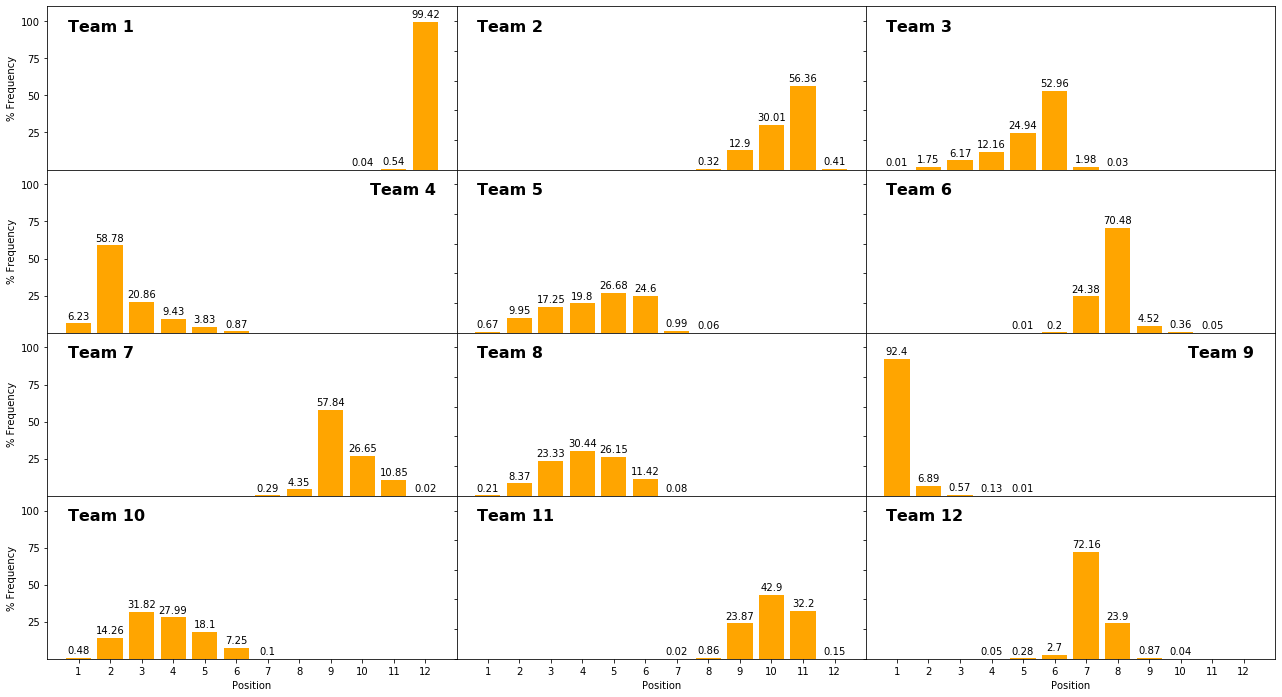

In [28]:
# Let's create a grid of subplots to show these predicted results

fig, ax = plt.subplots(4,3, figsize=(22,12))
fig.subplots_adjust(wspace = 0, hspace = 0)

axes = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1], ax[2,2], ax[3,0], ax[3,1], ax[3,2]]

for i,x in enumerate(axes):
    x.set_ylim(0,110)
    
    if i > 8:  # Set x labels at bottom of grid only
        x.set_xlabel('Position')
        x.set_xticks(np.arange(14))
        
        xlabels = np.array([''])
        xlabels = np.append(xlabels, np.arange(1,13))
        xlabels = np.append(xlabels, '')
        x.set_xticklabels(xlabels)         
    else:
        x.set_xticklabels([])
        
    if i%3 == 0:  # Set y labels at LHS of grid only
        x.set_ylabel('% Frequency')
        x.set_yticks([25,50,75,100])
    else:
        x.set_yticklabels([])
        
    if i == 3 or i == 8:  # Add Team numbers
        x.text(0.95, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='right', transform=x.transAxes)
    else:
        x.text(0.05, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='left', transform=x.transAxes)
    
    x.bar(np.arange(1,13), df_Results['Team_{}'.format(i+1)].values, color='orange')  # Plot bar charts
    
    for j,val in enumerate(df_Results['Team_{}'.format(i+1)].values):
        if val == 0.0:
            continue
        x.text(np.arange(1,13)[j], val+3, val, fontsize=10, ha='center')  # Add %values to bars

plt.show()

# Prediciton Summary

The MC has created a distribution of possible outcomes, with some notable outputs. The model appears very confident in choosing a winner in Team 9: ~93% and last place: Team 1: >99%! The greatest uncertainty in finishing position appears in predominantly in three clusters: from 2nd - 6th, 7th - 8th and 9th - 11th, with little overlap in between. The model therefore appears to be broadly confident in grouping teams into five distinct categories: first place, clusters 1-3 and last place.

# Race Results

The race results were published in the following week of June, which can now be taken for post-prediction analysis.

In [29]:
# Load in the new results data file

df_Race = pd.read_csv("/Users/dia1u17/Desktop/DataWork/Running_Projects/Mile_of_miles_full_results.csv")

df_Race = df_Race.drop(columns=['Team 1', 'Unnamed: 1', '10k']) # Drop unneccesary column names as before

df_Race = df_Race.dropna(how='all')  # Drop rows if all NaNs (i.e. between groups on the spreadsheet or added rows)


# Convert both 5k and race result mile times (i.e. 'Actual' column) to seconds and insert these new columns 

col_names = df_Race.columns  # Obtain column names as list

new_col_names = col_names.insert(1, '5k_secs')  # Choose position for new column name 
new_col_names = new_col_names.insert(2, 'Actual_secs')  # Choose position for second new column name 

df_Race['5k_secs'] = [mins_secs(time) for time in df_Race['5k'].values]  # Populate new column as 5k time in seconds
df_Race['Actual_secs'] = [mins_secs(time) for time in df_Race['Actual'].values]  # Populate new column as actual mile time in seconds

df_Race = df_Race[new_col_names]  # Re-order daatframe appropriately

df_Race.head() # The resulting dataframe looks like this ('Actual_secs' is the results column of interest):

,5k,5k_secs,Actual_secs,MoM17,MoM18,MoM19,MM17a,MM17b,MM17c,MM17d,...,MM18b,MM18c,MM18d,MM18e,MM19a,MM19b,MM19c,MM19d,MM19e,Actual
0,29:02:00,1742.0,440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:20
1,26:28:00,1588.0,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:22
2,28:59:00,1739.0,472.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:52
3,26:09:00,1569.0,480.0,NaN,NaN,NaN,07:03,NaN,06:53,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08:00
4,32:59:00,1979.0,650.0,NaN,NaN,NaN,08:06,NaN,08:03,08:06,...,NaN,09:34,09:03,NaN,NaN,NaN,09:32,09:13,09:19,10:50


In [30]:
Team_times = []  # Initialise list

mile_times = df_Race['Actual_secs'].values  # Extract race results

for i in range(12):  # Loop over 12 teams:
    team_total_time = np.sum(mile_times[i*10:10*(i+1)])  # We can sum over the results in blocks of 10 (= team size)
    Team_times.append(team_total_time)

print(Team_times)  # Returns a list of results, in order Team 1 - 12

[4672.0, 4468.0, 4213.0, 3893.0, 3861.0, 4185.0, 4470.0, 4232.0, 3927.0, 3970.0, 4432.0, 4456.0]


In [31]:
# Let's use another dictionary to order this list properly

d = {}  # Initialise dictionary
Team_order = []

Sorted_times = np.sort(Team_times)  # Sort by race time

for i,val in enumerate(df_Results):    
    d['{}'.format(Team_times[i])] = '{}'.format(val) # Fill the dictionary of times matched to teams

for time in Sorted_times:
    Team_order.append(d['{}'.format(time)])  # Create the ordered list by selecting times one-by-one

    
# Let's save this output to a dictionary, whilst printing these out to see which team finishes where:    
dict_pos = {}
    
for i,val in enumerate(Team_order):
    dict_pos['{}'.format(val)] = str(i+1)
    print('Pos {0}: {1}'.format(i+1, val))  # From 1st place to 12th

Pos 1: Team_5
Pos 2: Team_4
Pos 3: Team_9
Pos 4: Team_10
Pos 5: Team_6
Pos 6: Team_3
Pos 7: Team_8
Pos 8: Team_11
Pos 9: Team_12
Pos 10: Team_2
Pos 11: Team_7
Pos 12: Team_1


So, we know Team 5 was the eventual winner! Let's visualise this better.

In [32]:
# Now let's visualise these results in our prediction dataframe (final position highlighted in green)

def style_specific_cell(x):
    with pd.option_context('display.precision', 2):
        colour = 'background-color: lightgreen'
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        for i,val in enumerate(Team_order):
            loc = np.argwhere(val == x.columns.values)[0][0]
            df1.iloc[i,loc] = colour  # Highlight each finishing position in green

        return df1

pd.set_option('precision', 2)

df_Ordered.style.apply(style_specific_cell, axis=None)

,Team_9,Team_4,Team_10,Team_8,Team_5,Team_3,Team_12,Team_6,Team_7,Team_11,Team_2,Team_1
1st,92.40,6.23,0.48,0.21,0.67,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2nd,6.89,58.78,14.26,8.37,9.95,1.75,0.00,0.00,0.00,0.00,0.00,0.00
3rd,0.57,20.86,31.82,23.33,17.25,6.17,0.00,0.00,0.00,0.00,0.00,0.00
4th,0.13,9.43,27.99,30.44,19.80,12.16,0.05,0.00,0.00,0.00,0.00,0.00
5th,0.01,3.83,18.10,26.15,26.68,24.94,0.28,0.01,0.00,0.00,0.00,0.00
6th,0.00,0.87,7.25,11.42,24.60,52.96,2.70,0.20,0.00,0.00,0.00,0.00
7th,0.00,0.00,0.10,0.08,0.99,1.98,72.16,24.38,0.29,0.02,0.00,0.00
8th,0.00,0.00,0.00,0.00,0.06,0.03,23.90,70.48,4.35,0.86,0.32,0.00
9th,0.00,0.00,0.00,0.00,0.00,0.00,0.87,4.52,57.84,23.87,12.90,0.00
10th,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.36,26.65,42.90,30.01,0.04


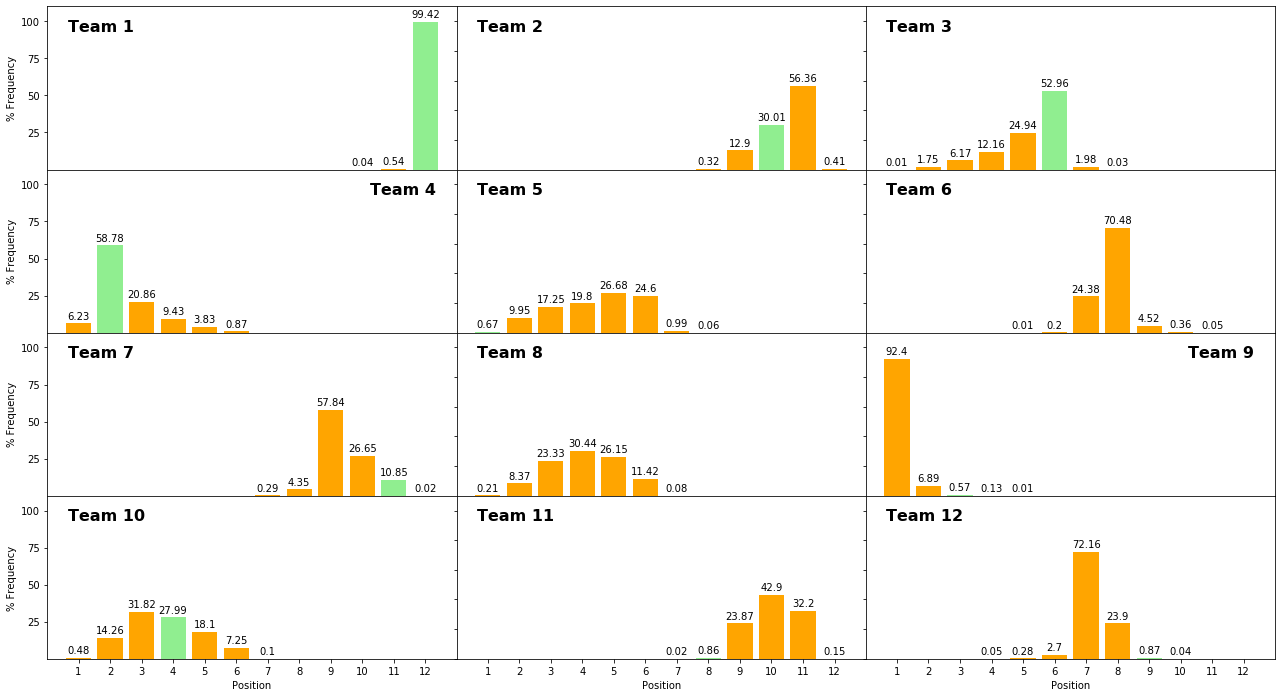

In [33]:
# Let's overlay these final positions onto our grid of subplots similarly

fig, ax = plt.subplots(4,3, figsize=(22,12))
fig.subplots_adjust(wspace = 0, hspace = 0)

axes = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2], ax[2,0], ax[2,1], ax[2,2], ax[3,0], ax[3,1], ax[3,2]]

for i,x in enumerate(axes):
    x.set_ylim(0,110)
    
    if i > 8:  # Set x labels at bottom of grid only
        x.set_xlabel('Position')
        x.set_xticks(np.arange(14))
        
        xlabels = np.array([''])
        xlabels = np.append(xlabels, np.arange(1,13))
        xlabels = np.append(xlabels, '')
        x.set_xticklabels(xlabels)         
    else:
        x.set_xticklabels([])
        
    if i%3 == 0:  # Set y labels at LHS of grid only
        x.set_ylabel('% Frequency')
        x.set_yticks([25,50,75,100])
    else:
        x.set_yticklabels([])
        
    if i == 3 or i == 8:  # Add Team numbers
        x.text(0.95, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='right', transform=x.transAxes)
    else:
        x.text(0.05, 0.85,'Team {}'.format(i+1), fontsize=16, fontweight='bold', ha='left', transform=x.transAxes)
    
    x.bar(np.arange(1,13), df_Results['Team_{}'.format(i+1)].values, color='orange')  # Plot bar charts
    
    # Now, plot actual finishing position in green
    Bars = np.zeros(12) 
    Position = int(dict_pos['Team_{}'.format(i+1)]) - 1  # Identify team position from dictionary
    Bars[Position] = df_Results['Team_{}'.format(i+1)].values[Position]
    
    x.bar(np.arange(1,13), Bars, color='lightgreen')  # Plot bar chart overlay
    
    
    for j,val in enumerate(df_Results['Team_{}'.format(i+1)].values):
        if val == 0.0:
            continue
        x.text(np.arange(1,13)[j], val+3, val, fontsize=10, ha='center')  # Add %values to bars

plt.show()

## Predicted vs Actual comparison

Let's round off this analysis with a direct comparison between predicted time from our model to the race results.

In [34]:
# Define our model predictions and create a dataframe of actual/predicted mile times (in secs) 

model_predictions = df['5k_secs'].apply(lambda time: (time - c_min) / m_min)

df_comp = pd.DataFrame({'Actual':df_Race['Actual_secs'], 'Predicted':model_predictions})

# Our new dataframe:
df_comp.head()

,Actual,Predicted
0,440.0,481.45
1,442.0,441.16
2,472.0,480.67
3,480.0,436.18
4,650.0,543.47


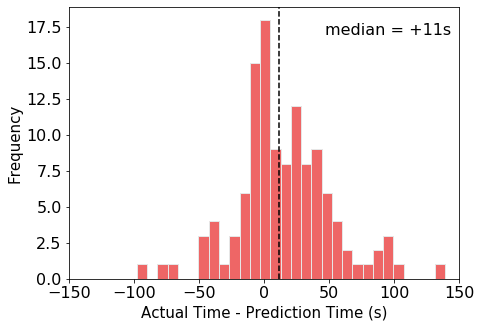

In [35]:
# So let's take the difference between race times and predicted times

diffs = df_comp['Actual'] - df_comp['Predicted']  # Time difference


# And create a histogram of these results:

matplotlib.rcParams.update({'font.size': 16})

plt.figure(figsize=(7,5))

plt.xlabel('Actual Time - Prediction Time (s)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

plt.hist(diffs, edgecolor='#E6E6E6', color='#EE6666', bins=30)  # Plot histogram

plt.axvline(np.median(diffs), color='black', linestyle='--')  # Plot median time difference

plt.xlim(-150,150)

plt.text(47,17, 'median = +{}s'.format(int(np.median(diffs))), fontsize=16)  # Display median time difference

plt.show()

In [36]:
# The precentage of mile times within +-11 seconds of their prediction:
print('Predictions within +- median: ', round(100*np.sum(abs(diffs) < 11) / len(diffs), 1),'%') 

Predictions within +- median:  33.3 %


So we see that the model predicted mile time is a (median) average of 11 seconds less than the actual mile time of runners in this sample. On average therefore, it tends towards predicting 'optimistic' (i.e. faster) mile times. Exactly a third of our predictions fall within 11 seconds of race results.

# Summary: where the model falls down and how to improve it

Of the 12 teams in the model, 6 produced results which were considered extremely low frequency occurrences (<1% in each case), including that of the winning team (Team 5). More broadly however, we find that the median prediction time is (only) 11 seconds out and the general trend of position predictions is certainly better than random chance, broadly correlating with our model predictions, but with large variance on these positions. In this, only one team (Team 5 again) is found to be more than 3 places removed from the model prediction.

Despite some limited success, it is clear we have some major pitfalls to address. Hence, the question: why did the model fall down in some cases, and by extension, how can we improve the model?

We can start by considering a breakdown of the individual results, as in the histogram above. Considering each runner, we see the model on average is +11 seconds 'too optimistic' in predicting a mile time. From examining the shape of the histogram, we see exactly 1/3 of runners fall within +-11 seconds of their predicted time. The shape of this histogram loosely conforms to a Gaussian distribution, with tails of the distribution reaching > +-50 seconds from their predicted time. It is likely that these few data points are responsible for the inaccuracy in the final predictions. This offers a simple, but effective, explanation for Team 5's surprise victory. In this specific case, there was a single runner with a recorded 5k time of > 24 mins (in 2020), but was in fact capable of a < 20 mins 5k (as evidenced by past results). The model therefore assigned a prediction on this runner that was not only inaccurate, but one that could not be mitigated for by our Gaussian errors. This is an example of where our input data may be be flawed, and if inputting poor quality data, we would expect poor quality results!

The nature of the input data is therefore of central importance. The main limitation is likely the selection of only a single, recent (2020) 5k time, as the standard to forecast from. An improved model would use a deeper set of input data, using not a single, but a range of (weighted) 5k times over longer timescales, i.e. pre-2020. A similar parameter which could be used to construct the model is a ranking/handicap score (such as those employed by RunBritain, see https://www.runbritainrankings.com/), which calculates a score for each runner based on past races, weighted by recency. This would help negate such disastrous miscalculations!   

It's worth bearing in mind that this competition was run in unprecidented times, following three months without any races or training, after a national lockdown. The model used historic data of an event run without these restrictions, and with the aforementioned observation bias towards faster runners (who were more likely to both race mile distances, and do so consistently). The impact of the 2020 lockdown on amateur running participation and form is a topic well beyond the scope of this mini-review, but I believe it is fair to assume the loss of group training has reduced the speed endurance of the average club runner, which would cause the model to overestimate the pace of the entire sample. 

It is also debatable whether Gaussian errors can well describe the random variations of any individual in a race situation -- which have many unseen variables affecting performance. It seems likely that many more negative factors exist to influence a race result (e.g. weather, health, injury, form, training) than positive ones, and as such, these model errors may not be best represented as symmetric, and should possibly show wider tails to capture the wider random variation of race day. A student-t distribution may achieve this, or perhaps a lognormal distribution. Beyond this simple MC model, a more advanced model could implement a Bayesian framework and use a lognormal or beta prior distribution to model individual performances, in order to better account for this uncertainty.

In summary, this toy-box model is successful only to a very limited extent, being most prominently restricted by the nature of input data to the model. It does however highlight an interesting case of how to build a simple MC model and visualise the results of the model, while remembering that for any model, the quality of input data is of paramount importance! 